# [GD-2] SentencePiece 사용하기

---

# 🗼 목차
Step 0. 라이브러리 불러오기  
Step 1. 데이터 전처리  
Step 2. 데이터 분석  
Step 3. SentencePiece 모델 학습  
Step 4. Tokenizer 함수 작성  
Step 5. 모델 학습  
Step 6. SentencePiece model 변경 (bpe)  
Step 7. vocab_size 조정

---

# Step 0. 라이브러리 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import konlpy

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.6.0
1.22.2
0.5.2


---

# Step 1. 데이터 전처리

## 1.1 데이터 불러오기

In [2]:
data = pd.read_table('~/aiffel/nsmc/ratings.txt')
data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [3]:
print('데이터 개수 : ', len(data))

데이터 개수 :  200000


## 1.2 결측치 제거

In [4]:
orig_len = len(data)

* `document` 컬럼에 결측치가 8개가 있다.

In [5]:
data.isnull().sum()

id          0
document    8
label       0
dtype: int64

* `dropna`를 사용하여 결측치를 제거해주자.

In [6]:
data_dropna = data.dropna(axis = 0)

print('결측치 제거 후 데이터 개수 : ', len(data_dropna))

결측치 제거 후 데이터 개수 :  199992


## 1.3 중복 제거

- 데이터프레임에서 중복 제거하려면 pandas의 `df.drop_duplicates`를 사용하면 된다.

In [7]:
cleaned_corpus = data_dropna.drop_duplicates(['document'])

print('중복 제거 후 데이터 개수 : ', len(cleaned_corpus))

중복 제거 후 데이터 개수 :  194543


* 200,000개의 데이터에서 결측치, 중복 제거하여 194,543개의 데이터가 남았다.

In [8]:
print('전처리 전 데이터 개수 : ', len(data))
print('결측치 제거 후 데이터 개수 : ', len(data_dropna))
print('중복 제거 후 데이터 개수 : ', len(cleaned_corpus))

전처리 전 데이터 개수 :  200000
결측치 제거 후 데이터 개수 :  199992
중복 제거 후 데이터 개수 :  194543


---

# Step 2. 데이터 분석

- 결측치, 중복을 제거한 데이터프레임에서 리뷰만 가져와 `review` 변수에 할당하였다.

In [9]:
review = cleaned_corpus['document']

- 각 리뷰의 길이를 구하여 `corpus_length`라는 컬럼을 생성하여 기존 데이터프레임에 추가하였다.

In [10]:
new_review = []

for i in review:
    new_review.append(len(i))

In [11]:
cleaned_corpus['corpus_length'] = new_review
cleaned_corpus

,id,document,label,corpus_length
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,19
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,137
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1,36
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1,54
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,27
...,...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0,14
199996,3302770,쓰.레.기,0,5
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0,33
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0,35


## 2.1 문장 길이 확인
* 문장의 길이 분포를 시각화하여 확인해보자.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


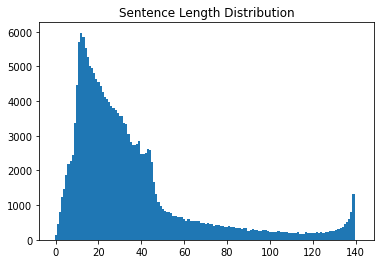

In [12]:
min_len = 999   # 임의로 절대로 min_len이 될 수 없는 수로 설정
max_len = 0     # 임의로 절대로 max_len이 될 수 없는 수로 설정
sum_len = 0

print("Data Size:", len(cleaned_corpus))

for sen in review:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(review))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 2.1.1 길이가 1인 문장
* 길이가 1인 문장이 무엇인지 확인해보자.

In [13]:
def check_sentence_with_length(review, length):
    count = 0
    
    for sen in review:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

* , ㅇ, ㅋ, ㅆ 등 의미없는 것들이 있는 반면, 굿, 짱, 잼, 쉣 등 의미가 담긴 단어가 있는 것을 확인할 수 있다.

In [14]:
check_sentence_with_length(review, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


### 2.1.2 길이가 긴 문장
* 대부분 데이터가 앞 쪽에 몰려있지만 최장길이 142 부근에도 데이터가 제법 있는 것으로 확인이 된다.
* 어떠한 문장인지 확인해보자.

In [15]:
check_sentence_with_length(review, 142)

영화 초반을 보면서 ' 좀 허항된 . 황당한 코믹스런 ' 연출이 되겠다란 생각을 하고 보기시작했는데 .. 연주가 처음 시작되는 부분에서 저도 모르게 눈가가 초촉해 지기시작하더군요 .. 이유는 모르겠네요 ... 자유에 대한 갈증과 박해에 대한 내용을 &gt


* 문장의 수가 140 이상인 문장 길이의 데이터에 어떠한 것이 있는지 인덱스로 추출해보자.

In [16]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 140 이상인 문장 길이를 추출합니다.
    if _sum >= 140:
        print("Outlier Index:", idx+1)

Outlier Index: 2
Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56
Outlier Index: 57


In [17]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495, 2625,
       2599, 2257, 1660, 1311, 1079,  968,  893,  844,  799,  789,  765,
        678,  686,  654,  658,  648,  614,  554,  600,  555,  544,  554,
        528,  528,  473,  493,  443,  477,  469,  443,  403,  437,  422,
        388,  398,  365,  372,  398,  380,  381,  326,  350,  327,  308,
        333,  332,  260,  286,  300,  281,  291,  255,  261,  271,  283,
        246,  231,  233,  223,  224,  244,  221,  223,  216,  211,  198,
        185,  206,  199,  215,  177,  178,  178,  219,  198,  199,  195,
        183,  221,  192,  226,  194,  218,  218,  247,  245,  252,  276,
        304,  350,  380,  452,  514,  589,  802, 1328,    0,    1])

## 2.2 최장 길이(max_len) 정하기

- 데이터의 길이 별 분포를 확인하기 위해 `box plot`을 그려보았다.

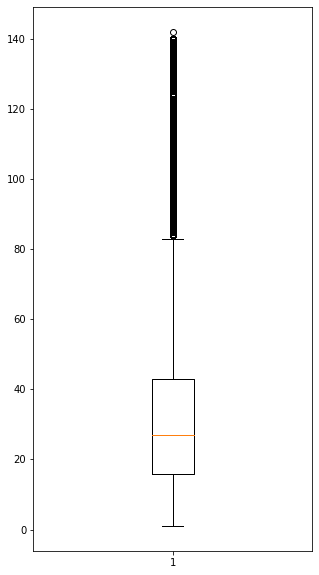

In [18]:
text_len = [len(sen) for sen in review]

plt.figure(figsize = (5,10))
plt.boxplot(text_len)
plt.show()

- 조금 더 정확한 수치를 파악하기 위해서 사분위수를 구하였다.
- [[Pandas로 사분위수 구하기]](https://sosomemo.tistory.com/34)
- [[box plot 참고 자료]](https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85)

In [19]:
num = pd.Series(text_len)

Q1 = num.quantile(.25)
Q2 = num.quantile(.5)
Q3 = num.quantile(.75)
IQR = Q3 - Q1
MAX = Q3 + (1.5 * IQR)

print('Q1 = ', Q1)  # 제 1사분위수
print('Q2 = ', Q2)  # 중위수
print('Q3 = ', Q3)   #제 3사분위수
print('IQR = ', IQR)  # 사분위간 범위
print('MAX = ', MAX)  # 최댓값

Q1 =  16.0
Q2 =  27.0
Q3 =  43.0
IQR =  27.0
MAX =  83.5


In [20]:
# below_threshold_len : 데이터의 몇 %가 최대 길이 안에 들어오는지 계산하는 함수

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
print('=3')

=3


- 너무 많은 데이터를 제거하면 안 될 것 같아 `max_len`을 100, 또는 최댓값인 83으로 설정하였으나 정확도가 매우 떨어져 제3사분위수로 설정하여 진행해보았다.

In [21]:
below_threshold_len(max_len, review)
below_threshold_len(83, review)   # 최댓값 
below_threshold_len(60, review)  
below_threshold_len(43, review)   # 제 3사분위수

전체 샘플 중 길이가 142 이하인 샘플의 비율: 100.0
전체 샘플 중 길이가 83 이하인 샘플의 비율: 91.43839665266805
전체 샘플 중 길이가 60 이하인 샘플의 비율: 85.86739178484962
전체 샘플 중 길이가 43 이하인 샘플의 비율: 75.63160843618121


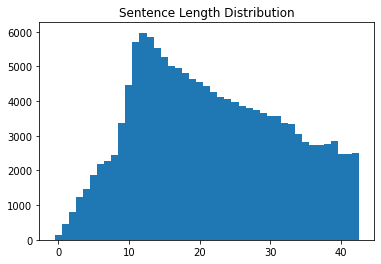

In [22]:
max_len = 43

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in review if len(s) <= max_len]

removed_data = cleaned_corpus[cleaned_corpus['corpus_length']<= max_len]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [23]:
removed_data

,id,document,label,corpus_length
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,19
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1,36
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,27
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1,29
6,9279041,완전 감동입니다 다시봐도 감동,1,16
...,...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0,14
199996,3302770,쓰.레.기,0,5
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0,33
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0,35


In [24]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495])

In [25]:
print('전처리 전 데이터 개수 : ', len(data))
print('결측치 제거 후 데이터 개수 : ', len(data_dropna))
print('중복 제거 후 데이터 개수 : ', len(cleaned_corpus))
print('maxlen 설정 후 데이터 개수 : ', len(removed_data))
print('최종 데이터 양(%) : ', (len(removed_data) / len(data) * 100))

전처리 전 데이터 개수 :  200000
결측치 제거 후 데이터 개수 :  199992
중복 제거 후 데이터 개수 :  194543
maxlen 설정 후 데이터 개수 :  147136
최종 데이터 양(%) :  73.568


---

# Step 3. SentencePiece 모델 학습
- model_type으로 디폴트 적용이 되어 있는 `unigram`으로 하여 SentencePiece 모델을 학습해보자.
- `vocab_size`는 8,000으로 하여 우선 진행해보기로 한다.  
- ▼ SentencePiece 관련 자료  
[[참고 자료1]](https://paul-hyun.github.io/vocab-with-sentencepiece/)
[[참고 자료2]](https://data-make.tistory.com/692)
[[참고 자료3]](http://tensorboy.com/bpe-sentencepiece) 

In [26]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in removed_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 721922 Mar 22 07:37 korean_spm_25000.model
-rw-r--r-- 1 root root 506744 Mar 22 07:37 korean_spm_25000.vocab
-rw-r--r-- 1 root root 703107 Mar 22 07:54 korean_spm_bpe_25000.model
-rw-r--r-- 1 root root 429299 Mar 22 07:54 korean_spm_bpe_25000.vocab
-rw-r--r-- 1 root root 370646 Mar 22 08:23 korean_spm_bpe.model
-rw-r--r-- 1 root root 115848 Mar 22 08:23 korean_spm_bpe.vocab
-rw-r--r-- 1 root root 375259 Mar 22 08:27 korean_spm.model
-rw-r--r-- 1 root root 144741 Mar 22 08:27 korean_spm.vocab


In [27]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1616, 10, 409, 16, 1586, 10, 160, 13, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


---

# Step 4. Tokenizer 함수 작성
- 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list를 전달한다. 
- 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환한다.  
- 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장이기에 바로 학습에 사용할 수 있게 Padding해야 한다.

In [28]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [29]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 476 3136   15 1092 3057    4    0    0    0    0]
 [1539 2140  219  540   10    3   18 7910  814    7]]


---

# Step 5. 모델 학습

## 5.1 데이터 분리

In [30]:
tensor, word_index, index_word = sp_tokenize(s, removed_data['document'])

In [31]:
tensor

array([[1183,  174,  281, ...,    0,    0,    0],
       [3102, 1838,  583, ...,    0,    0,    0],
       [  51,  175,  331, ...,    0,    0,    0],
       ...,
       [  84, 5122,   29, ...,    0,    0,    0],
       [  48,  343, 4997, ...,    0,    0,    0],
       [1414, 1611,  395, ...,    0,    0,    0]], dtype=int32)

In [32]:
len(tensor)

147136

In [33]:
removed_label = np.array(removed_data['label'])

In [34]:
removed_label

array([1, 1, 1, ..., 0, 0, 0])

In [35]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(tensor, removed_label, test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)

In [36]:
print('train 데이터 개수 : ', len(x_train))
print('val 데이터 개수 : ', len(x_val))
print('test 데이터 개수 : ', len(x_test))
print('리뷰 데이터 총 개수 : ', len(x_train)+len(x_val)+len(x_test))

print('---------------------')

print('train label 데이터 개수 : ', len(y_train))
print('val label 데이터 개수 : ', len(y_val))
print('test label 데이터 개수 : ', len(y_test))
print('라벨 데이터 총 개수 : ', len(y_train)+len(y_val)+len(y_test))

train 데이터 개수 :  94166
val 데이터 개수 :  29428
test 데이터 개수 :  23542
리뷰 데이터 총 개수 :  147136
---------------------
train label 데이터 개수 :  94166
val label 데이터 개수 :  29428
test label 데이터 개수 :  23542
라벨 데이터 총 개수 :  147136


## 5.2 모델 구성 및 훈련 (RNN 모델)

In [37]:
vocab_size = 10000   # 단어사진 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경 가능한 하이퍼파라마터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model.add(tf.keras.layers.LSTM(8))  # LSTM 레이어 사용 & LSTM 벡터의 차원 수 변경 가능
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs = 10

history = model.fit(x_train,
                    y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (x_val, y_val),
                    verbose = 1)

Epoch 1/10
184/184 [==============================] - 10s 42ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 2/10
184/184 [==============================] - 8s 41ms/step - loss: 0.6908 - accuracy: 0.5066 - val_loss: 0.6195 - val_accuracy: 0.7608
Epoch 3/10
184/184 [==============================] - 7s 41ms/step - loss: 0.4608 - accuracy: 0.8087 - val_loss: 0.3787 - val_accuracy: 0.8350
Epoch 4/10
184/184 [==============================] - 8s 42ms/step - loss: 0.3411 - accuracy: 0.8577 - val_loss: 0.3612 - val_accuracy: 0.8414
Epoch 5/10
184/184 [==============================] - 7s 40ms/step - loss: 0.3177 - accuracy: 0.8681 - val_loss: 0.3632 - val_accuracy: 0.8377
Epoch 6/10
184/184 [==============================] - 7s 41ms/step - loss: 0.3067 - accuracy: 0.8728 - val_loss: 0.3609 - val_accuracy: 0.8405
Epoch 7/10
184/184 [==============================] - 7s 41ms/step - loss: 0.2985 - accuracy: 0.8764 - val_loss: 0.3612 - val_accuracy: 0.840

In [39]:
results = model.evaluate(x_test, y_test, verbose = 2)
print(results)

736/736 - 3s - loss: 0.3918 - accuracy: 0.8397
[0.391817182302475, 0.8397332429885864]


In [40]:
history_dict = history.history

print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- 위에서 모델 학습하며 나온 `accuracy`와 `loss`를 그래프로 시각화하였다.
- loss 값은 에포크 3 ~ 4에서 급격히 떨어졌으며, accuracy도 에포크 3 ~ 4에서 급격히 올라간 것을 확인할 수 있다.

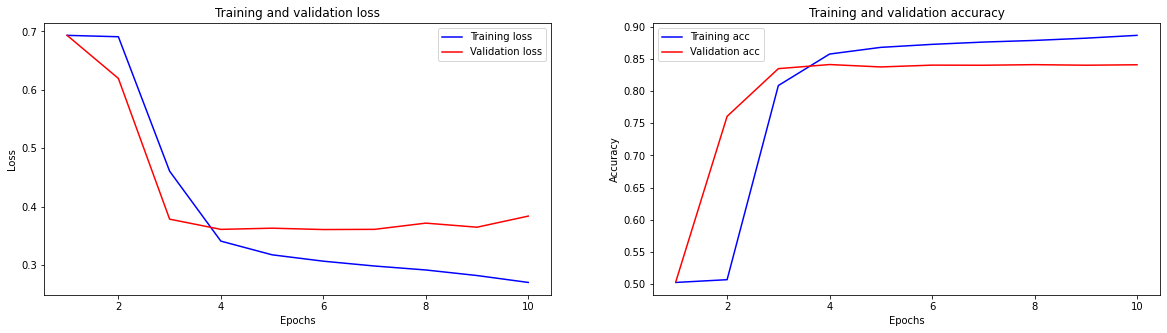

In [41]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

# Step 6. SentencePiece model 변경 (bpe)
- model_type으로 unigram이 아닌 `bpe`로 하여 SentencePiece 모델을 학습해보자.
- vocab_size는 동일하게 8,000으로 한다.
- BPE(Byte Pair Encoding)
    - 모든 단어를 문자(바이트)들의 집합으로 취급하여 자주 등장하는 문자 쌍을 합치면, 접두어나 접미어의 의미를 캐치할 수 있고, 처음 등장하는 단어는 문자(알파벳)들의 조합으로 나타내어 OOV 문제를 완전히 해결할 수 있다.
    - 하지만 어떤 기준으로 결합해서 문장을 복원할 지에 대한 해결책이 크게 없기에 완벽하다 할 수 없다.

## 6.1 SentencePiece 모델 학습

In [42]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in removed_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l korean_spm_bpe*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm_bpe --model_type=bpe --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm_bpe
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_

-rw-r--r-- 1 root root 703107 Mar 22 07:54 korean_spm_bpe_25000.model
-rw-r--r-- 1 root root 429299 Mar 22 07:54 korean_spm_bpe_25000.vocab
-rw-r--r-- 1 root root 370456 Mar 22 08:29 korean_spm_bpe.model
-rw-r--r-- 1 root root 115658 Mar 22 08:29 korean_spm_bpe.vocab


- '아버지가'가 '아버', '지가'로 된 것을 확인할 수 있다.
- unigram과는 다르게 토큰화되었다.

In [43]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_bpe.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[6062, 995, 6535, 6252, 1604, 6245, 6357, 6238, 6236]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## 6.2 Tokenizer 함수

In [44]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_bpe.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [45]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 646 2980 6267  559  844 6236    0    0    0]
 [1680 2218  272  364 6245  172 7699   17    7]]


## 6.3 모델 구성 및 훈련

In [46]:
vocab_size = 10000   # 단어사진 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경 가능한 하이퍼파라마터)

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model_2.add(tf.keras.layers.LSTM(8))  # LSTM 레이어 사용 & LSTM 벡터의 차원 수 변경 가능
model_2.add(tf.keras.layers.Dense(8, activation = 'relu'))
model_2.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_2.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

epochs = 10

history_2 = model.fit(x_train,
                      y_train,
                      epochs = epochs,
                      batch_size = 512,
                      validation_data = (x_val, y_val),
                      verbose = 1)

Epoch 1/10
184/184 [==============================] - 7s 40ms/step - loss: 0.2555 - accuracy: 0.8914 - val_loss: 0.3904 - val_accuracy: 0.8398
Epoch 2/10
184/184 [==============================] - 7s 39ms/step - loss: 0.2425 - accuracy: 0.8965 - val_loss: 0.4089 - val_accuracy: 0.8394
Epoch 3/10
184/184 [==============================] - 7s 40ms/step - loss: 0.2305 - accuracy: 0.9004 - val_loss: 0.4168 - val_accuracy: 0.8364
Epoch 4/10
184/184 [==============================] - 7s 39ms/step - loss: 0.2192 - accuracy: 0.9042 - val_loss: 0.4549 - val_accuracy: 0.8364
Epoch 5/10
184/184 [==============================] - 7s 41ms/step - loss: 0.2112 - accuracy: 0.9079 - val_loss: 0.4504 - val_accuracy: 0.8359
Epoch 6/10
184/184 [==============================] - 7s 40ms/step - loss: 0.2039 - accuracy: 0.9101 - val_loss: 0.4895 - val_accuracy: 0.8340
Epoch 7/10
184/184 [==============================] - 8s 41ms/step - loss: 0.1971 - accuracy: 0.9122 - val_loss: 0.4654 - val_accuracy: 0.8298

In [48]:
results_2 = model_2.evaluate(x_test, y_test, verbose = 2)
print(results_2)

736/736 - 4s - loss: 0.6934 - accuracy: 0.4979
[0.6934155821800232, 0.4978761374950409]


In [49]:
history_2_dict = history_2.history

print(history_2_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


- training loss는 계속 감소하는 반면에 validation loss는 계속해서 증가한다.
- accuracy도 마찬가지로 train accuracy는 계속 증가하는 반면에 validation accuracy는 계속 감소한다.

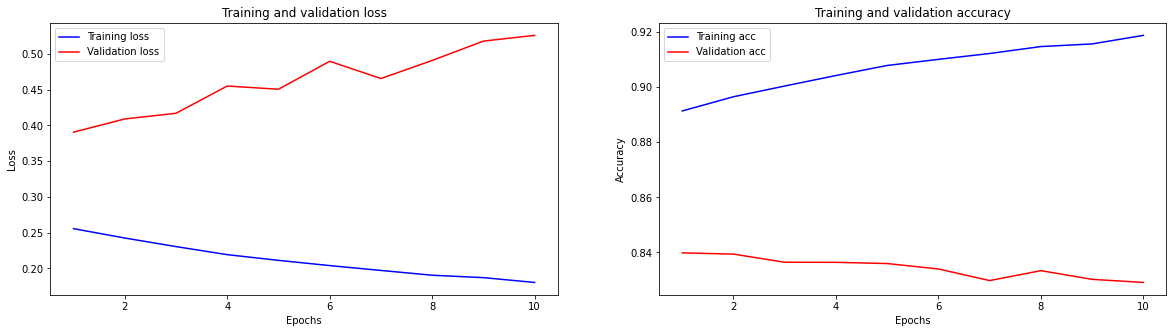

In [50]:
acc = history_2_dict['accuracy']
val_acc = history_2_dict['val_accuracy']

loss = history_2_dict['loss']
val_loss = history_2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

# Step 7. vocab_size 조정
- `SentencePiece`의 `vocab_size`을 25,000 ~ 32,000으로 하여 실제 모델을 학습시킨다고 하여 25,000으로 설정하였다.
- [[vocab_size 관련 참고 자료 1]](https://lsjsj92.tistory.com/600)
- [[vocab_size 관련 참고 자료 2]](https://keep-steady.tistory.com/37)

## 7.1 SentencePiece(unigram)

In [51]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 25000

with open(temp_file, 'w') as f:
    for row in removed_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_25000 --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_25000*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm_25000 --vocab_size=25000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm_25000
  model_type: UNIGRAM
  vocab_size: 25000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_voc

-rw-r--r-- 1 root root 721295 Mar 22 08:31 korean_spm_25000.model
-rw-r--r-- 1 root root 505806 Mar 22 08:31 korean_spm_25000.vocab


In [52]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm_25000.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[8236, 641, 19, 1639, 11, 277, 21, 3]
['▁아버지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [53]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_25000.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [54]:
vocab_size = 10000   # 단어사진 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경 가능한 하이퍼파라마터)

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model_3.add(tf.keras.layers.LSTM(8))  # LSTM 레이어 사용 & LSTM 벡터의 차원 수 변경 가능
model_3.add(tf.keras.layers.Dense(8, activation = 'relu'))
model_3.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [55]:
model_3.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

epochs = 10

history_3 = model.fit(x_train,
                      y_train,
                      epochs = epochs,
                      batch_size = 512,
                      validation_data = (x_val, y_val),
                      verbose = 1)

Epoch 1/10
184/184 [==============================] - 8s 41ms/step - loss: 0.1757 - accuracy: 0.9195 - val_loss: 0.5374 - val_accuracy: 0.8300
Epoch 2/10
184/184 [==============================] - 7s 40ms/step - loss: 0.1708 - accuracy: 0.9216 - val_loss: 0.5634 - val_accuracy: 0.8296
Epoch 3/10
184/184 [==============================] - 7s 40ms/step - loss: 0.1672 - accuracy: 0.9227 - val_loss: 0.5598 - val_accuracy: 0.8269
Epoch 4/10
184/184 [==============================] - 7s 40ms/step - loss: 0.1662 - accuracy: 0.9213 - val_loss: 0.6067 - val_accuracy: 0.8252
Epoch 5/10
184/184 [==============================] - 7s 40ms/step - loss: 0.1644 - accuracy: 0.9231 - val_loss: 0.5462 - val_accuracy: 0.8280
Epoch 6/10
184/184 [==============================] - 7s 41ms/step - loss: 0.1606 - accuracy: 0.9233 - val_loss: 0.5580 - val_accuracy: 0.8206
Epoch 7/10
184/184 [==============================] - 7s 41ms/step - loss: 0.1574 - accuracy: 0.9254 - val_loss: 0.5869 - val_accuracy: 0.8261

- `vocab_size`를 조정하였는데, accuracy가 매우 낮아진 것을 확인할 수 있다.

In [56]:
results_3 = model_3.evaluate(x_test, y_test, verbose = 2)
print(results_3)

736/736 - 4s - loss: 0.6932 - accuracy: 0.5021
[0.6931953430175781, 0.5021238923072815]


## 7.2 SentencePiece(bpe)

- `bpe` model type에서 `vocab_size`를 늘렸는데, 코드가 실행이 되지 않았다.

In [ ]:
# import sentencepiece as spm
# import os
# temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

# vocab_size = 25000

# with open(temp_file, 'w') as f:
#     for row in removed_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
#         f.write(str(row) + '\n')

# spm.SentencePieceTrainer.Train(
#     '--input={} --model_prefix=korean_spm_bpe_25000 --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
# )

# !ls -l korean_spm_bpe_25000*

---

# 🌞 회고

## 1) 알게 된 점
- 프로젝트 초반에는 데이터 중 'document' 컬럼의 데이터만을 다뤘는데, 모델 훈련을 하려고 하니 'label' 데이터 처리도 해야 했다.
- 이 부분에서 다소 헤매었는데 나름 알고리즘 수업에서 배운 것들과 다른 곳에서 본 것들을 총 동원하여 코드를 작성해보니 되었다...만만세 
- 데이터의 최장 길이(max_len)를 설정하는데, 이전 관련 노드에서는 데이터를 최대한 살리는 것이 결과가 좋았으나 이번 노드에서는 그럴수록 결과가 좋지 않았다.
- 처음에는 다른 코드의 문제인줄 알고 이것저것 해보았는데, 알고 보니 최장 길이 문제였다.
- 그래서 여러가지 해본후, 사분위수를 구해서 3사분위수로 설정하여 해보았더니 결과가 가장 좋게 나왔다.
- SentencePiece의 model_type을 적용하는 부분에서 여러 자료를 참고하며 코드를 작성해서 조금 더 잘 알게 되었다.
- RNN 모델로 학습하는 부분은 익스 6번을 참고하였으며 다시 해당 내용을 상기시킬 수 있었다.

## 2) 결과
- `unigram`으로 SentencePiece 모델을 학습하였을 때 `loss: 0.3918 - accuracy: 0.8397`의 결과가 나왔다.
- `bpm`으로 SentencePiece 모델을 학습하였을 때는 `loss: 0.6934 - accuracy: 0.4979`로 accuracy가 매우 떨어진 것을 확인할 수 있다.
- train accuracy는 높으나 val accuracy가 낮으며 test 데이터로 평가했을 때 accuracy가 매우 낮았다.
- `bpm`으로 토크나이징하였을 때,  '아버지'라는 단어가 분리되었다. 이렇게 의미가 있는 단어도 분리를 하여 accuracy가 낮은 것은 아닐까 추측한다.
- `vocab_size`를 보통 25,000 ~ 32,000로 한다고 하여 25,000으로 조정 후 학습하였는데, 결과가 좋지 않게 나왔다.
- 너무 크게 해서 오히려 필요 없는 단어들이 생성되서 그런 것은 아닌가라는 생각이 드는데 조금 더 확인해볼 필요가 있는 것 같다..❗
- `bpe`의 경우, vocab_size를 키웠을 때 코드가 실행되지 않았는데 왜 이런 오류가 발생했을까....

## 3) 후기
- 처음 진행한 Going Deeper NLP 프로젝트로 더욱 잘하고 싶어서 최선을 다했다.
- 이전 노드와는 달리 내가 전반적인 구성을 생각하여 그에 맞춰 실행하다보니 시행착오가 많았다.
- 하지만 그만큼 여러가지 많이 배울 수 있었다.
- 이제 시작이긴 하지만 여태 했던 NLP 프로젝트 중 가장 재미있게 했다.

## 4) 참고 자료
- [[E-06] Sentiment_Classification](https://github.com/aramssong/aiffel/blob/main/%5BE-06%5D%20Sentiment_Classification.ipynb) 
- [[E-08] News_Summarize](https://github.com/aramssong/aiffel/blob/main/%5BE-08%5D%20News_Summarize.ipynb)
- [다른 분 프로젝트 코드](https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-02%5DSentencePiece.ipynb)